In [154]:
# General
from random import randint
import json
import requests
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
# Data Handling
from pyarrow import parquet as pq
from datetime import datetime as dt
from datetime import timezone
from dateutil import parser
import pickle
# Plotting
import matplotlib.pyplot as plt
# Machine Learning
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import xgboost as xgb #BDT

In [155]:
# Global dates
def FileDate(minDString, maxDString):
    MINDATE_DT = parser.parse(minDString)
    MINDATE_STR = MINDATE_DT.strftime("%m-%d-%Y")
    MINDATE_TS = MINDATE_DT.timestamp()
    MAXDATE_DT = parser.parse(maxDString)
    MAXDATE_STR = MAXDATE_DT.strftime("%m-%d-%Y")
    MAXDATE_TS = MAXDATE_DT.timestamp()
    FILEDATE = ""

    if (MAXDATE_TS < MINDATE_TS):
        print("ERROR: Given dates are not in chronological order.")
        return

    if MINDATE_DT and MAXDATE_DT:
        same_m = MINDATE_DT.strftime("%m") == MAXDATE_DT.strftime("%m")
        same_d = MINDATE_DT.strftime("%d") == MAXDATE_DT.strftime("%d")
        same_y = MINDATE_DT.strftime("%Y") == MAXDATE_DT.strftime("%Y")
        if same_m and same_d and same_y:
            FILEDATE = MINDATE_STR
        elif same_m and same_y:
            FILEDATE = "{0}-{1}to{2}-{3}".format(MINDATE_DT.strftime("%m"),
                                                 MINDATE_DT.strftime("%d"),
                                                 MAXDATE_DT.strftime("%d"),
                                                 MINDATE_DT.strftime("%Y"))
        elif same_y:
            FILEDATE = "{0}-{1}to{2}".format(MINDATE_DT.strftime("%m"),
                                             MINDATE_DT.strftime("%d"),
                                             MAXDATE_STR)
        else:
            FILEDATE = "{0}to{1}".format(MINDATE_STR, MAXDATE_STR)
            
    return FILEDATE

## 1. Retrieval

#### 1.1 Get XRootD data

In [156]:
# Get parquet files
xRootD_fDate = FileDate("Jun 1 00:00:00 UTC 2019", "Jun 30 23:59:59 UTC 2019")
xRootD_ds = pq.ParquetDataset("parquet/XRootD_"+xRootD_fDate)
xRootD_table = xRootD_ds.read()

# Convert to pandas dataframe
xRootD_df = xRootD_table.to_pandas()

#### 1.2 Get ClassAds data

In [157]:
# Get parquet files
classAds_fDate = FileDate("Jun 23 00:00:00 UTC 2019", "Jun 29 23:59:59 UTC 2019")
classAds_ds = pq.ParquetDataset("parquet/ClassAds_"+classAds_fDate)
classAds_table = classAds_ds.read()

# Convert to pandas dataframe
classAds_df = classAds_table.to_pandas()

## 2. Preprocessing

#### 2.1 Add bookkeeping columns to XRootD dataframe

In [158]:
workflow_idFront = (xRootD_df.app_info.str.split('/').str[-1]
                                      .str.split(':').str[:2]
                                      .str.join('_')
                   ) # Front half of workflow_id
workflow_idBack = (xRootD_df.app_info.str.split('/').str[-1]
                                     .str.split(':').str[2:]
                                     .str.join('_')
                  ) # Back half of workflow_id
xRootD_df["workflow_id"] = workflow_idFront.map(str)+":"+workflow_idBack
xRootD_df["crab_id"] = xRootD_df.app_info.str.split('_').str[0]
xRootD_df["job_id"] = xRootD_df.crab_id.map(str)+"/"+xRootD_df.workflow_id
xRootD_df["start_datetime"] = pd.to_datetime(xRootD_df.start_time, unit="ms")

#### 2.2 Add bookkeeping columns to ClassAds dataframe

In [159]:
classAds_df["workflow_id"] = classAds_df.workflow_id.map(str)+"_"+classAds_df.retries.astype(str)
classAds_df["job_id"] = classAds_df.crab_id.map(str)+"/"+classAds_df.workflow_id
classAds_df["start_datetime"] = pd.to_datetime(classAds_df.start_time, unit="ms")

#### 2.2 Make XRootD preselection

In [160]:
# Require real crab jobs
xRootD_df = xRootD_df[(~xRootD_df.crab_id.isna()) & (xRootD_df.job_id != "/:")]

In [164]:
xRootD_df["inClassAds"] = xRootD_df.job_id.isin(list(classAds_df.job_id.values))
# Print percent coverage
xRootD_inClassAds = xRootD_df.inClassAds.value_counts()
print("{0:.2f}%".format(xRootD_inClassAds[True]/(xRootD_inClassAds[True]+xRootD_inClassAds[False])*100),
      "XRootD jobs are recorded in ClassAds")

13.53% XRootD jobs are recorded in ClassAds


#### 2.3 Make ClassAds preselection

In [161]:
# Require at UCSD or CalTech exclusively
classAds_df = classAds_df[classAds_df.site.isin(["T2_US_UCSD", "T2_US_Caltech"])]
# Require real crab jobs
classAds_df = classAds_df[(~classAds_df.crab_id.isna()) & (classAds_df.job_id != "/")]

In [162]:
classAds_df["inXRootD"] = classAds_df.job_id.isin(list(xRootD_df.job_id.values))
# Print percent coverage
classAds_inXRootD = classAds_df.inXRootD.value_counts()
print("{0:.2f}%".format(classAds_inXRootD[True]/(classAds_inXRootD[True]+classAds_inXRootD[False])*100),
      "ClassAds jobs are recorded in XRootD")

83.83% ClassAds jobs are recorded in XRootD


#### 2.4 Add training-related columns to ClassAds

In [163]:
lookups = {}
excludes = ["job_id", "site"]
keys = classAds_df.keys()
for k, dtype in enumerate(classAds_df.dtypes):
    if dtype == "object":
        key = keys[k]
        if key not in excludes:
            print("Converting {} values to numerical values...".format(key))
            excludes.append(key)
            nkey = key+"NumId" if "_" in key else key+"_numId"
            lookups[key] = list(classAds_df[key].unique())
            classAds_df[nkey] = list(map(lambda x: lookups[key].index(x), classAds_df[key].values))

Converting dataset values to numerical values...
Converting workflow_id values to numerical values...
Converting crab_id values to numerical values...
Converting schedd_name values to numerical values...
Converting primaryDataset_primary values to numerical values...
Converting primaryDataset_processed values to numerical values...
Converting primaryDataTier values to numerical values...
Converting task values to numerical values...
Converting user_hn values to numerical values...


## 3. Select Features for Training

In [165]:
excludes += ["inXRootD", "start_datetime", "start_time"]
features = sorted(list(set(classAds_df.columns.values)-set(excludes)))

# Display selected features
print("{0} Selected Features:\n{1}\n".format(len(features), ", ".join(features)))
# Display excluded features
print("{0} Excluded Features.".format(len(excludes)))

21 Selected Features:
cpuTime, cpus, crab_idNumId, dataset_numId, exitCode, primaryDataTier_numId, primaryDataset_primaryNumId, primaryDataset_processedNumId, read_bytes, read_ops, read_segs, read_time, read_vops, retries, schedd_nameNumId, task_numId, user_hnNumId, walltime, workflow_idNumId, write_bytes, write_time

14 Excluded Features.


In [166]:
# Confirm that selected features are properly typed
classAds_df[features].dtypes

cpuTime                          float64
cpus                               int64
crab_idNumId                       int64
dataset_numId                      int64
exitCode                           int64
primaryDataTier_numId              int64
primaryDataset_primaryNumId        int64
primaryDataset_processedNumId      int64
read_bytes                       float64
read_ops                         float64
read_segs                        float64
read_time                        float64
read_vops                        float64
retries                            int64
schedd_nameNumId                   int64
task_numId                         int64
user_hnNumId                       int64
walltime                         float64
workflow_idNumId                   int64
write_bytes                      float64
write_time                       float64
dtype: object

/net/top/homes/jguiang/.virtualenvs/tuda-bdt/lib/python3.6/site-packages/numpy/lib/histograms.py:778: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


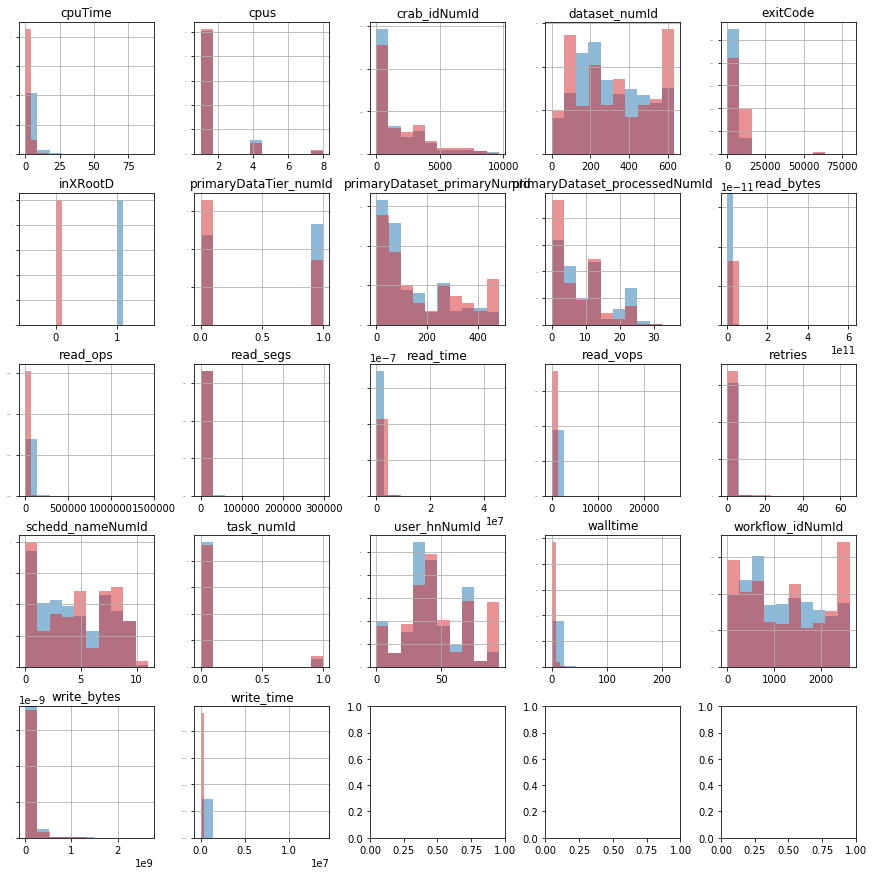

In [167]:
# Plot feature shapes
fig, axes = plt.subplots(5,5,figsize=(15,15))
toPlot = classAds_df[features+["inXRootD"]]
ax = toPlot[(toPlot.inXRootD)].hist(ax=axes.flatten()[:len(toPlot.keys())],
                                    alpha=0.5, color="C0", ylabelsize=0, 
                                    density=True)
ax = toPlot[~(toPlot.inXRootD)].hist(ax=axes.flatten()[:len(toPlot.keys())], 
                                     alpha=0.5, color="C3", ylabelsize=0, 
                                     density=True)

## 4. Train BDT

#### 4.1 Prepare data for training

In [168]:
# Split dataframe for training and testing
dummyWeights = np.ones(len(classAds_df.inXRootD)) # in place of dfs["weights"]
x_train, x_test, y_train, y_test, weights_train, weights_test = train_test_split(
                                                                                classAds_df,
                                                                                (~classAds_df.inXRootD),
                                                                                dummyWeights,
                                                                                test_size=0.25, random_state=42,
                                                                                )
print("Training Data: {}".format(x_train.shape))
print("Testing Data: {}".format(x_test.shape))

Training Data: (92016, 35)
Testing Data: (30672, 35)


#### 4.2 Set up BDT

In [169]:
# BDT Input
dtrain = xgb.DMatrix(x_train[features], label=y_train, weight=np.abs(weights_train))
dtest = xgb.DMatrix(x_test[features], label=y_test, weight=np.abs(weights_test))
evallist = [(dtrain,'train'), (dtest,'eval')]

# BDT Parameters Setup
param = {}
param['objective'] = 'binary:logistic'

# BDT Knobs (Parameters)
num_round = 200                 # Number of training rounds
param['eta'] = 0.1              # Step size shrinkage (alias: learning_rate)
param['max_depth'] = 3          # Max. depth of tree: larger = more complex = more prone to overfitting
param['verbosity'] = 1          # 0 (silent), 1 (warning), 2 (info), 3 (debug)
param['nthread'] = 8            # Number of parallel threads
param['eval_metric'] = "auc"    # Evaluation metrics for validation data. 'auc' = Area Under the Curve
param['subsample'] = 0.6        # Subsample ratio of the training instances
param['alpha'] = 8.0            # L1 regularization term on weights: Larger = more conservative
param['gamma'] = 2.0            # Min. loss rediction to make leaf (alias: min_split_loss)
param['lambda'] = 1.0           # L2 regularization term on weights: Larger = more conservative
param['min_child_weight'] = 1.0 # Minimum sum of instance weight (hessian) needed in a child
param['colsample_bytree'] = 1.0 # The subsample ratio of columns when constructing each tree

/net/top/homes/jguiang/.virtualenvs/tuda-bdt/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [170]:
# Get pos/neg weights
sumw_pos = np.abs(dtrain.get_weight()[dtrain.get_label()==1]).sum()
sumw_neg = np.abs(dtrain.get_weight()[dtrain.get_label()==0]).sum()
param["scale_pos_weight"] = sumw_neg/sumw_pos

#### 4.3 Train BDT

In [171]:
bst = xgb.train(param.items(), dtrain, num_round, evallist, early_stopping_rounds=15, verbose_eval=False)

[0]	train-auc:0.72874	eval-auc:0.726766
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 15 rounds.
[1]	train-auc:0.741178	eval-auc:0.741757
[2]	train-auc:0.740847	eval-auc:0.741022
[3]	train-auc:0.754358	eval-auc:0.756269
[4]	train-auc:0.780091	eval-auc:0.780355
[5]	train-auc:0.786854	eval-auc:0.786859
[6]	train-auc:0.791697	eval-auc:0.79064
[7]	train-auc:0.798343	eval-auc:0.79666
[8]	train-auc:0.804131	eval-auc:0.80255
[9]	train-auc:0.809027	eval-auc:0.808385
[10]	train-auc:0.81257	eval-auc:0.811923
[11]	train-auc:0.821089	eval-auc:0.821732
[12]	train-auc:0.825309	eval-auc:0.825788
[13]	train-auc:0.828099	eval-auc:0.828553
[14]	train-auc:0.829871	eval-auc:0.830313
[15]	train-auc:0.830982	eval-auc:0.831211
[16]	train-auc:0.835839	eval-auc:0.836291
[17]	train-auc:0.83709	eval-auc:0.837759
[18]	train-auc:0.839592	eval-auc:0.84016
[19]	train-auc:0.841427	eval-auc:0.842254
[20]	train-auc:0.842667	eval-auc:0.8

## 5. Evaluate Performance

#### 5.1 Plot ROC curves

In [172]:
# Get predictions
preds_train = bst.predict(xgb.DMatrix(x_train[features]))
preds_test = bst.predict(xgb.DMatrix(x_test[features]))

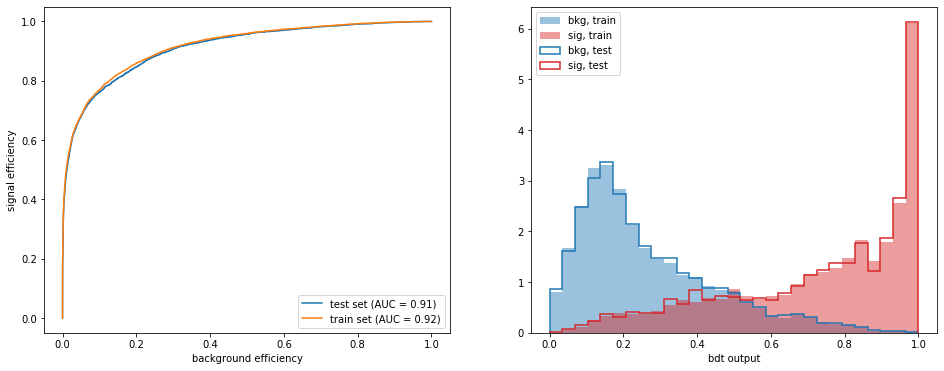

In [173]:
# Suplots setup
fig, axes = plt.subplots(1,2,figsize=(16,6))

# Subplot 1: Plot ROC curves
plt.subplot(1, 2, 1)
# Test ROC Curve
fpr, tpr, thresh = roc_curve(y_test,preds_test)
plt.plot(fpr, tpr, label="test set (AUC = {:.2f})".format(np.trapz(tpr,fpr)));
# Train ROC Curve
fpr, tpr, thresh = roc_curve(y_train,preds_train)
plt.plot(fpr, tpr, label="train set (AUC = {:.2f})".format(np.trapz(tpr,fpr)));
# Settings
plt.xlabel("background efficiency");
plt.ylabel("signal efficiency");
plt.legend();

# Subplot 2: Plot distribution of BDT outputs
plt.subplot(1, 2, 2)
bins = np.linspace(0.,1.,30)
# Training - Background
plt.hist(preds_train[y_train==0], weights=weights_train[y_train==0],
         bins=bins, histtype="stepfilled", alpha=0.45, 
         density=True, label="bkg, train",color="C0");
# Training - Signal
plt.hist(preds_train[y_train==1], weights=weights_train[y_train==1],
         bins=bins, histtype="stepfilled", alpha=0.45, 
         density=True, label="sig, train",color="C3");
# Testing - Background
plt.hist(preds_test[y_test==0], weights=weights_test[y_test==0],
         bins=bins, histtype="step", alpha=1.0, 
         density=True, label="bkg, test",color="C0",
         lw=1.5, linestyle="solid");
# Testing - Signal
plt.hist(preds_test[y_test==1], weights=weights_test[y_test==1],
         bins=bins, histtype="step", alpha=1.0, 
         density=True, label="sig, test",color="C3",
         lw=1.5, linestyle="solid");
# Settings
plt.xlabel("bdt output");
plt.legend(loc=2);

#### 5.2 List top 10 features

In [174]:
from functools import reduce

# Get feature scores
gainScore = pd.DataFrame(bst.get_score(importance_type='gain').items(), columns=['feature', 'gain'])
coverScore = pd.DataFrame(bst.get_score(importance_type='cover').items(), columns=['feature', 'cover'])
weightScore = pd.DataFrame(bst.get_score(importance_type='weight').items(), columns=['feature', 'weight'])
# Merge scores into single dataframe along feature column
scores = reduce(lambda left,right: pd.merge(left,right,on='feature'), [gainScore, coverScore, weightScore])
# Display top ten features in 'gain'
scores.sort_values('gain', ascending=False)[:10]

,feature,gain,cover,weight
0,read_segs,1081.768896,7959.609887,61
9,primaryDataTier_numId,554.354757,11387.972600,14
6,read_bytes,269.903455,3855.673499,53
5,read_ops,249.343025,10777.754111,54
4,read_time,246.321975,7962.333827,169
10,exitCode,234.881404,8771.189052,31
3,cpuTime,229.561070,7361.054544,185
8,workflow_idNumId,222.617408,7158.704874,98
1,dataset_numId,208.617686,6086.536148,54
19,task_numId,201.661424,1742.777699,9


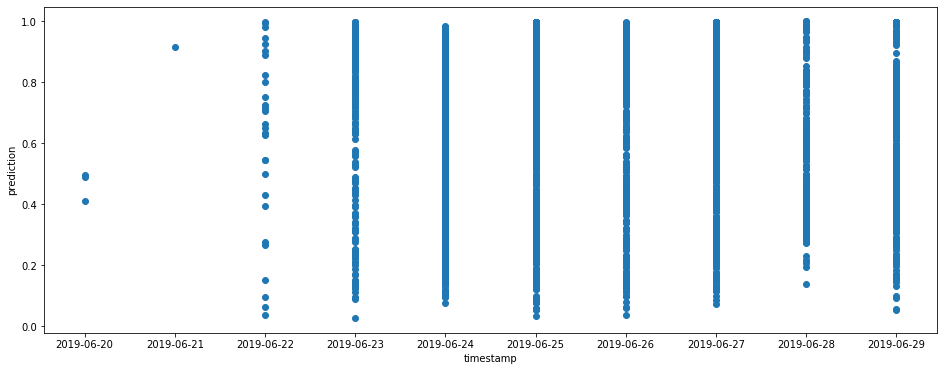

In [175]:
from matplotlib.colors import LogNorm

# Suplots setup
fig, axes = plt.subplots(1,1,figsize=(16,6))

# Subplot 1: Plot correlation btwn predictions and Higgs mass
plt.subplot(1, 1, 1)
# Correlation btwn predictions and Higgs mass
h2 = plt.plot_date(x_test["start_datetime"][~(x_test.inXRootD) == 1].dt.date, preds_test[y_test == 1]);
# Settings
plt.xlabel("timestamp");
plt.ylabel("prediction");

In [177]:
# Write BDT model and test data to pickle file
pickle.dump(bst, open("bdt.pkl", "wb"))
x_test.to_pickle("x_test.pkl", compression="gzip")
# Write features to JSON
with open("features.json", "w") as fout:
    json.dump(features, fout)

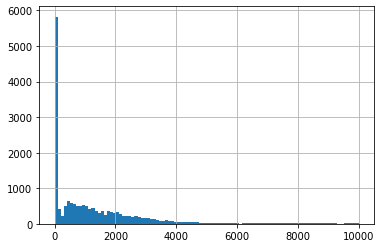

In [193]:
classAds_df[~classAds_df.inXRootD].read_segs.hist(bins=np.linspace(0,1e4,100))

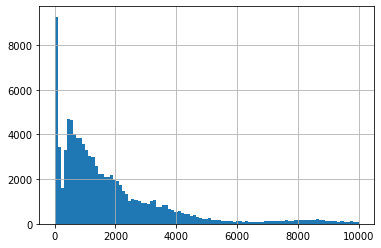

In [194]:
classAds_df[classAds_df.inXRootD].read_segs.hist(bins=np.linspace(0,1e4,100))

In [196]:
lookups["primaryDataTier"]

['MINIAODSIM', 'MINIAOD']

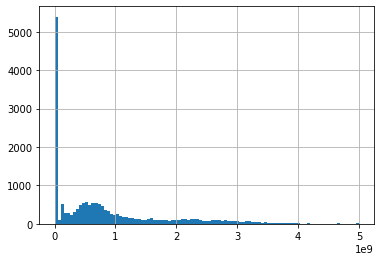

In [205]:
classAds_df[~classAds_df.inXRootD].read_bytes.hist(bins=np.linspace(0,5e9+1,100))

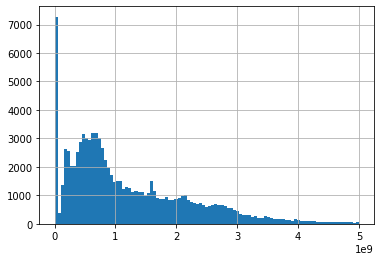

In [206]:
classAds_df[classAds_df.inXRootD].read_bytes.hist(bins=np.linspace(0,5e9+1,100))

In [208]:
# classAds_df.to_pickle("./pickle_jar/ClassAds_06-23to29-2019.pkl")
# xRootD_df.to_pickle("./pickle_jar/XRootD_06-01to30-2019.pkl")
import json
with open("lookups.json", "w") as fout:
    json.dump(lookups, fout)